This file contains linear regression and back test analysis for some stock market stock's.
if you want to just focus in one stock, change SAMPLE_STOCK_NAME value from None to that stock's file name in stock-samples folder, then you will only see plots that are related to that stock. Also if you want to focus on the Closing price only, you can change the SAMPLE_COLUMN_NAME to Close in order to only see plots relating to that column. 

### Importing packages

In [1]:
from holder.stock_holder import StockHolder
from backtest.simulator.bakctest_simulator import BackTestSimulator
from regression.LinearRegressionModel import LinearRegressionModel
from regression.linear_regression_simulator import LrSimulator

## Data

### Defining some parameters

In [2]:
MOVING_AVERAGE_LIST = [(4, 8), (3, 5), (5, 15), (10, 20), (10, 30), (10, 40), (20, 30), (20, 40), (20, 50)]

SAVE_DATA = False

INITIAL_CASH = 100000
MARKET_COMMISSION = 0.01

SAMPLE_STOCK_NAME = 'MAPNA' # change it to None to get all plots for all stocks
SAMPLE_COLUMN_NAME = 'Close' # change it to None to get all plots for all columns

### Reading sample data

In [3]:
stock_holder = StockHolder(save_data=SAVE_DATA)

### data stats view

stock stats:
<bound method NDFrame.describe of        Name       Date     High      Low    Close    Volume     Open
0     MAPNA 2019-10-28   8756.0   8570.0   8644.0   3396670   8507.0
1     MAPNA 2019-10-30   8990.0   8705.0   8849.0   6929651   8644.0
2     MAPNA 2019-11-02   9105.0   8428.0   8822.0   3698112   8850.0
3     MAPNA 2019-11-03   8958.0   8600.0   8798.0   7748497   8822.0
4     MAPNA 2019-11-04   8970.0   8426.0   8607.0   4271485   8798.0
...     ...        ...      ...      ...      ...       ...      ...
1088  MAPNA 2024-10-13  11560.0  11130.0  11200.0  15671221  11470.0
1089  MAPNA 2024-10-14  11190.0  10870.0  11070.0   4432100  11200.0
1090  MAPNA 2024-10-15  10740.0  10740.0  11050.0    750361  11070.0
1091  MAPNA 2024-10-16  10720.0  10720.0  10990.0   1729490  11050.0
1092  MAPNA 2024-10-19  10670.0  10670.0  10950.0   1500022  10990.0

[1093 rows x 7 columns]>


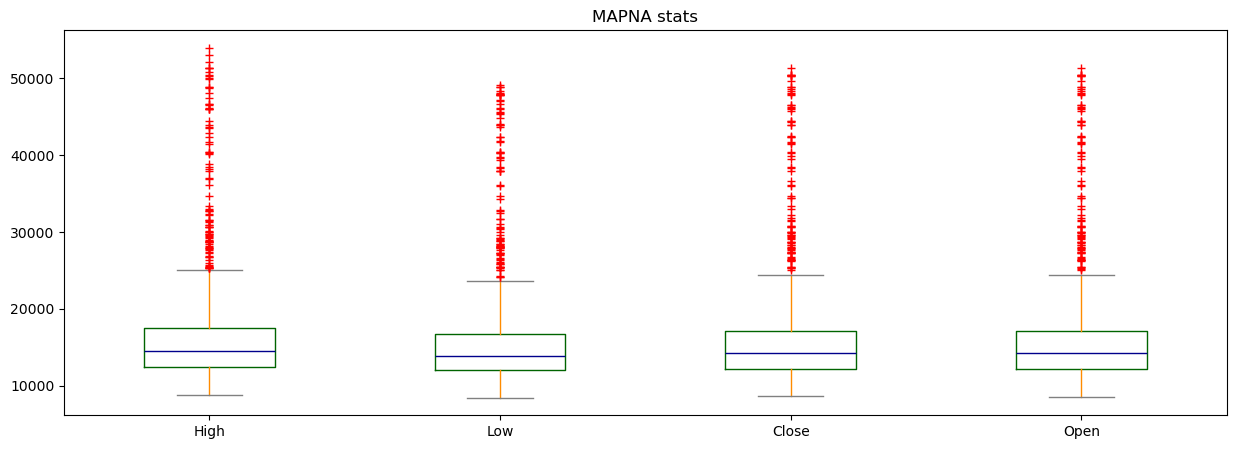

In [4]:
stock_holder.describe_plot(SAMPLE_STOCK_NAME)

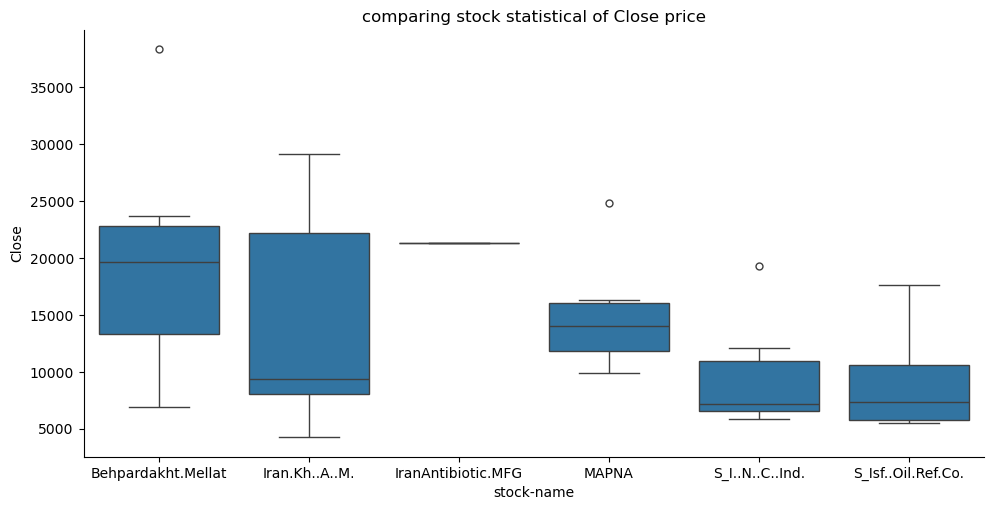

In [5]:
stock_holder.describe_together_single_col(col=SAMPLE_COLUMN_NAME)
# stock_holder.describe_together_all_cols() # for comparing stats of all columns

### closing - opening price

last 100 days

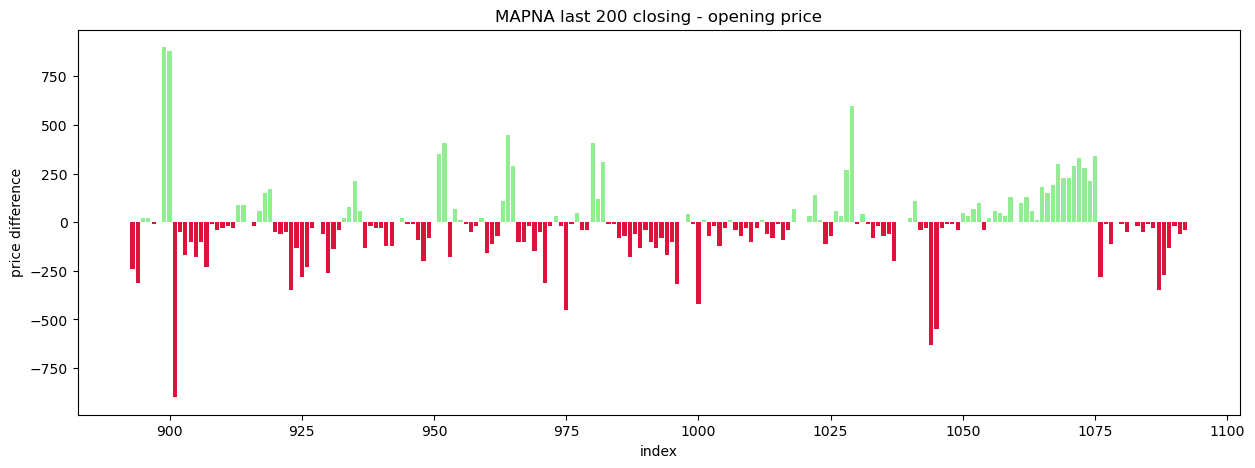

In [6]:
stock_holder.close_open_diff(SAMPLE_STOCK_NAME, period_in_day=200, is_head=False)

#### year by year mean

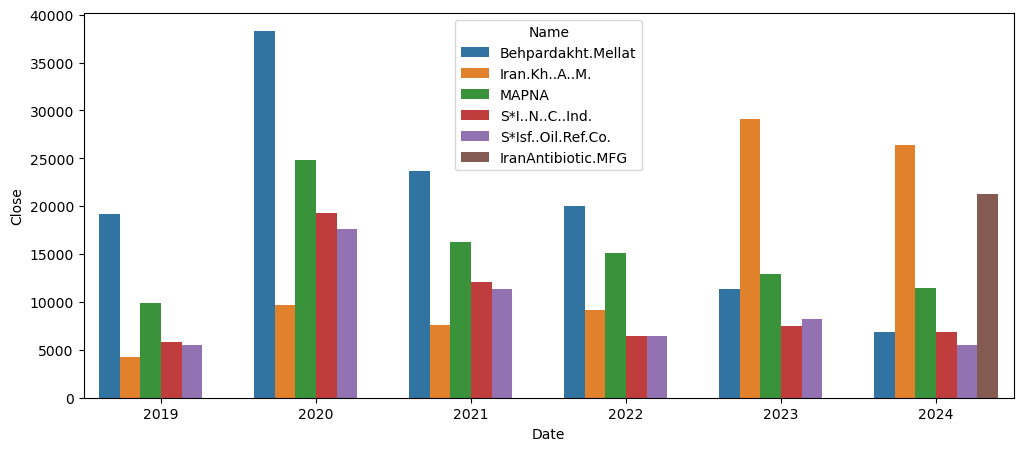

In [7]:
stock_holder.year_mean_compare(col=SAMPLE_COLUMN_NAME)

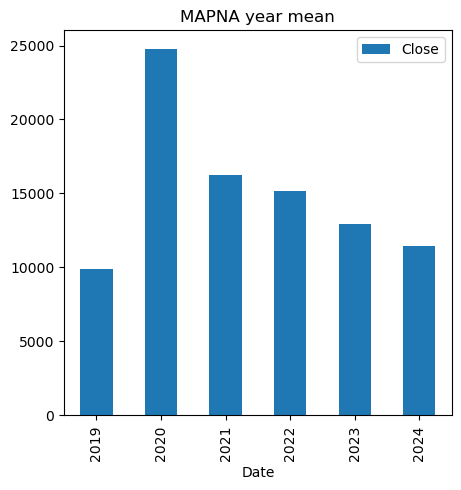

In [8]:
stock_holder.year_mean(SAMPLE_STOCK_NAME, col=SAMPLE_COLUMN_NAME, figsize=(5, 5))

#### each year mean - average of last five years

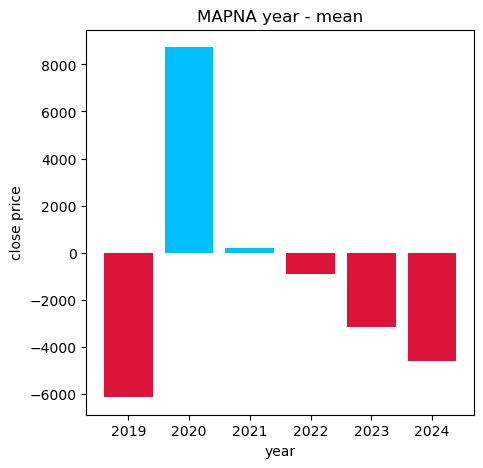

In [9]:
stock_holder.year_mean_diff(SAMPLE_STOCK_NAME, col=SAMPLE_COLUMN_NAME, figsize=(5, 5))

### Data visualization

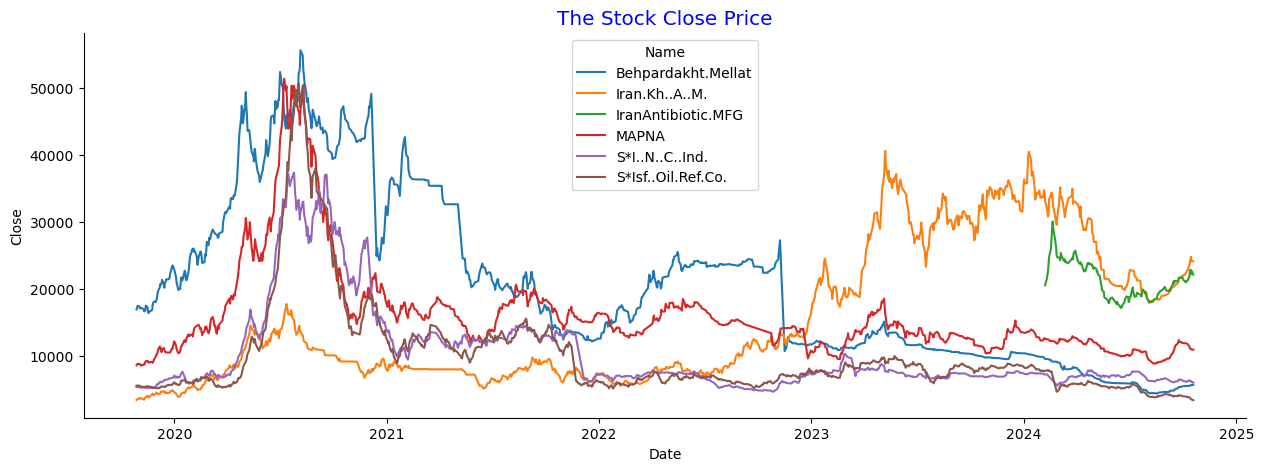

In [10]:
stock_holder.data_plot_compare(col=SAMPLE_COLUMN_NAME)

single stock

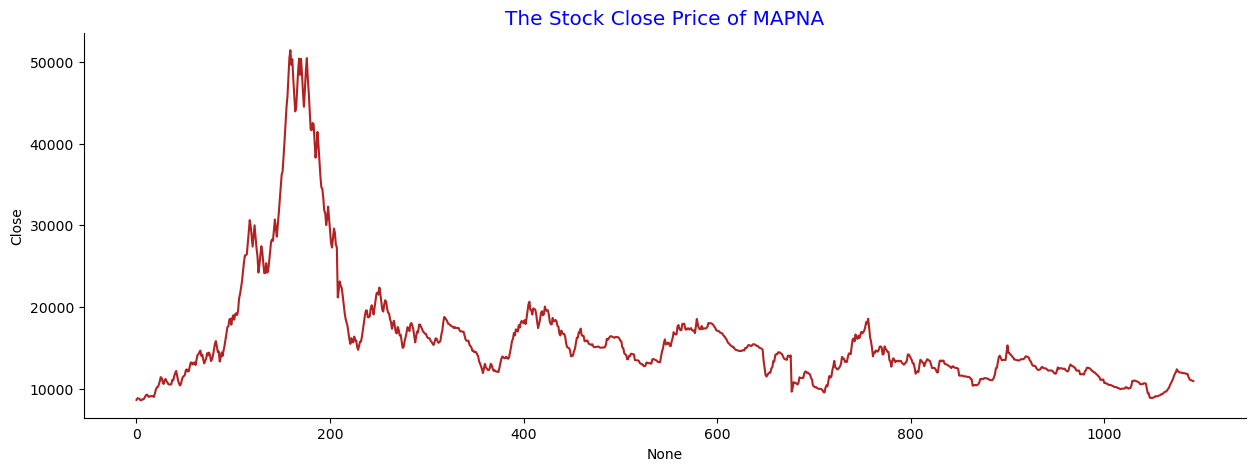

In [11]:
stock_holder.data_plot_single_stock(SAMPLE_STOCK_NAME, col=SAMPLE_COLUMN_NAME,
                                    is_number_index=True)  # change it to false in order to get date index

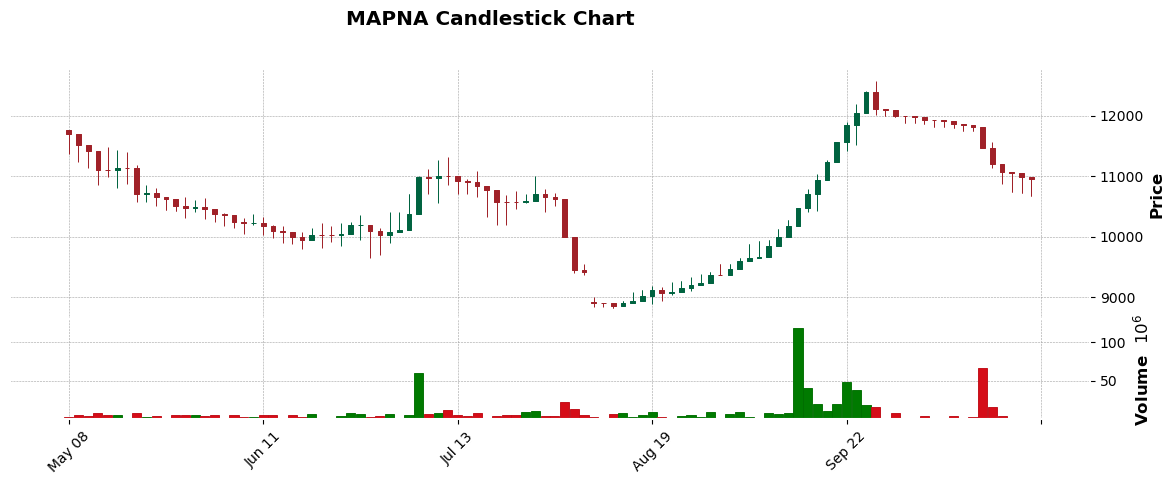

In [12]:
stock_holder.mpf_last_days_view(SAMPLE_STOCK_NAME, days=100)

## Moving Average Simulation

In [13]:
simulator = BackTestSimulator(stock_holder.get_samples(), stock_holder.get_stock_names(), [(1, 2), *MOVING_AVERAGE_LIST], save_data=SAVE_DATA, market_commission=MARKET_COMMISSION)
simulator.simulate(is_log_disabled=True)

#### General View

<IPython.core.display.Javascript object>

{'MAPNA': {'period': '(20, 50)',
  'profit-loss': -14385.800000000047,
  'profit-loss-percentage': -1.4385800000000046,
  'trade-no': 22}}

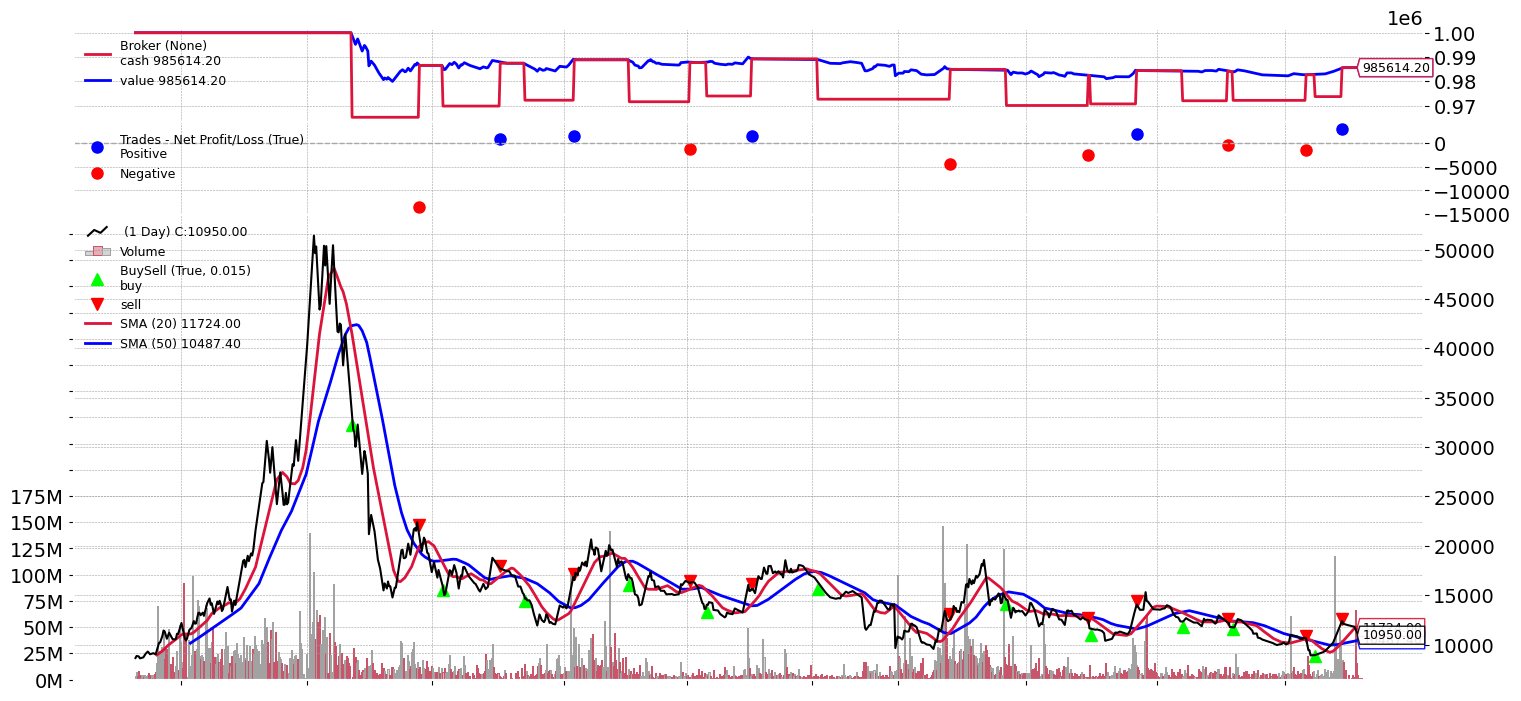

In [27]:
# simulator.best_stock_ma_comparison(SAMPLE_STOCK_NAME, figsize=(15, 7))

#### SMA result

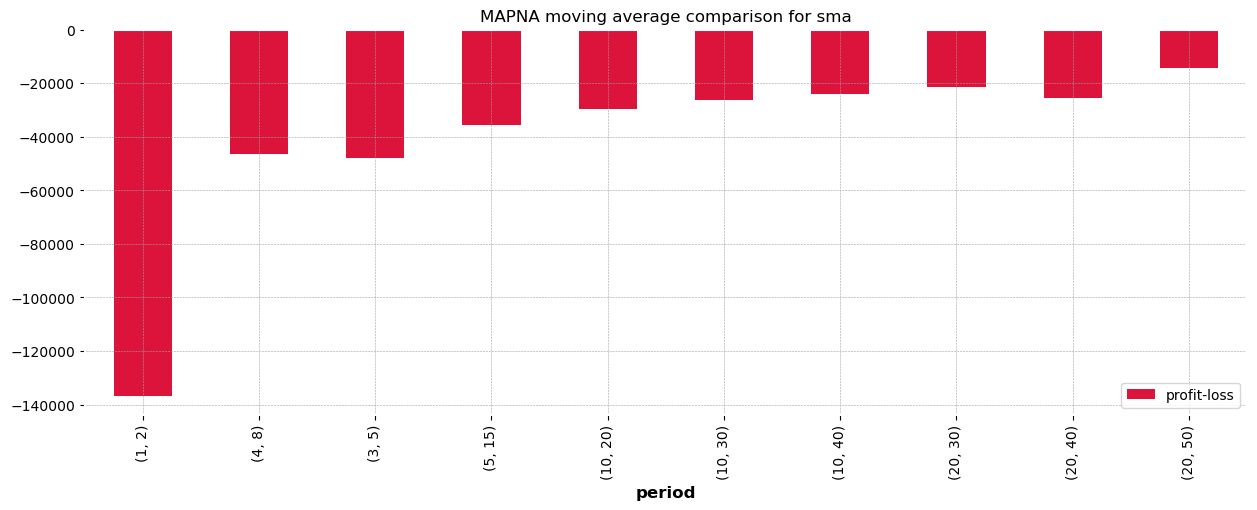

In [15]:
simulator.stock_ma_compare_plot(SAMPLE_STOCK_NAME, sma=True)

#### EMA result

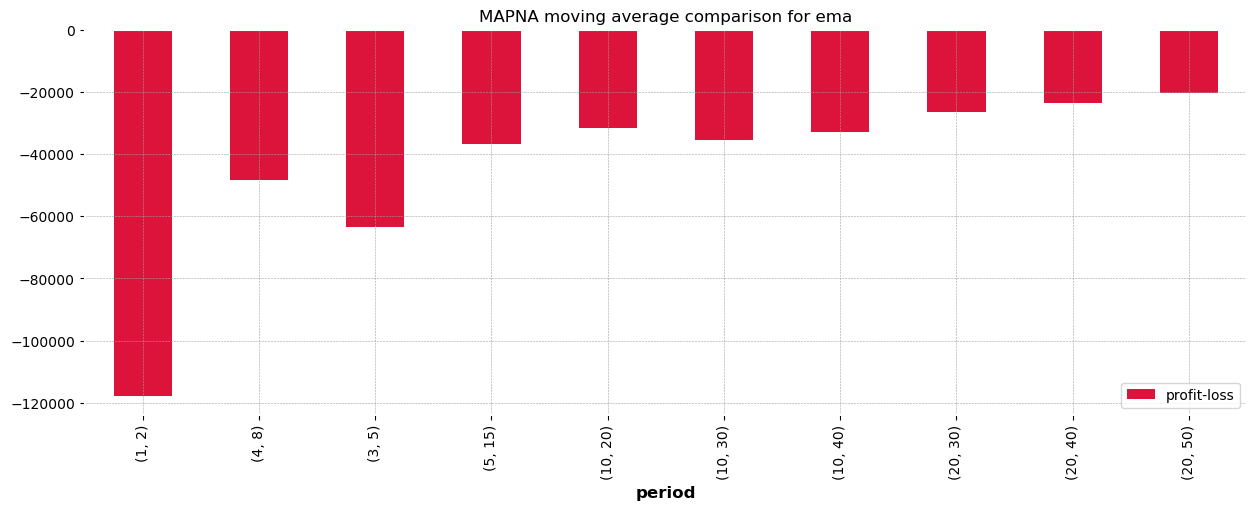

In [16]:
simulator.stock_ma_compare_plot(SAMPLE_STOCK_NAME, sma=False)

#### Comparing EMA vs SMA

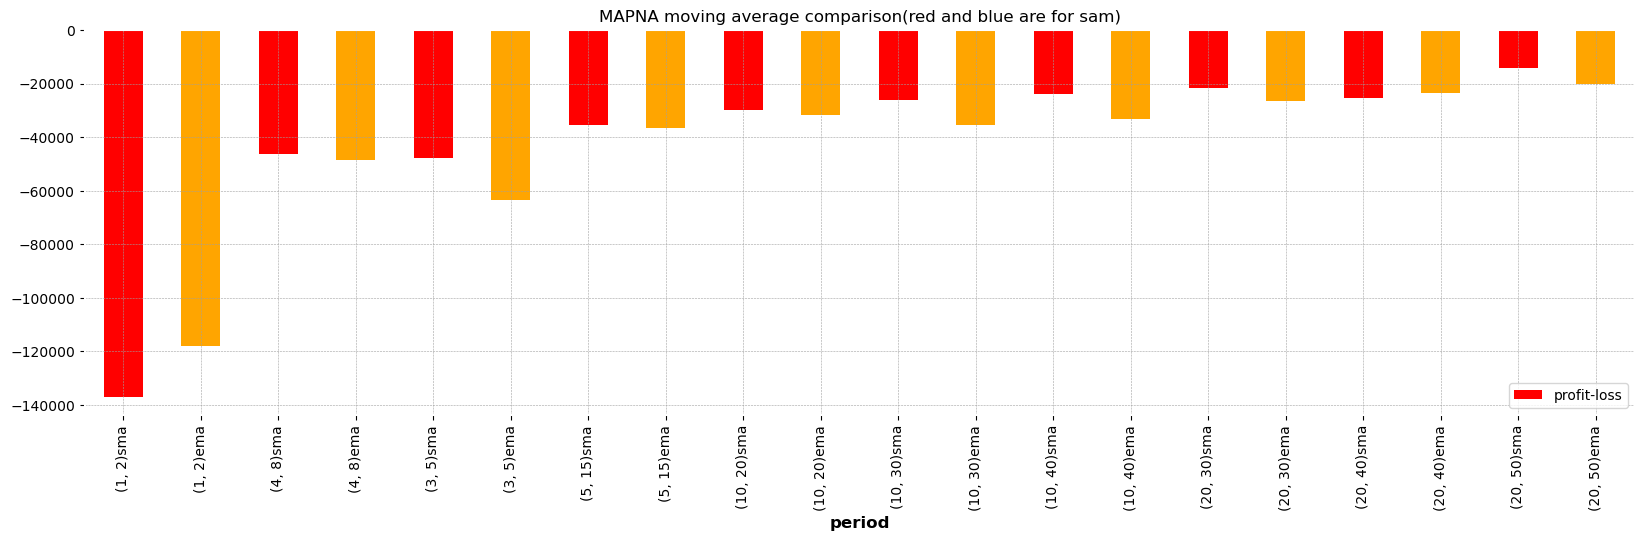

In [17]:
simulator.stock_ma_compare_plot(SAMPLE_STOCK_NAME, sma=None, figsize=(20, 5))

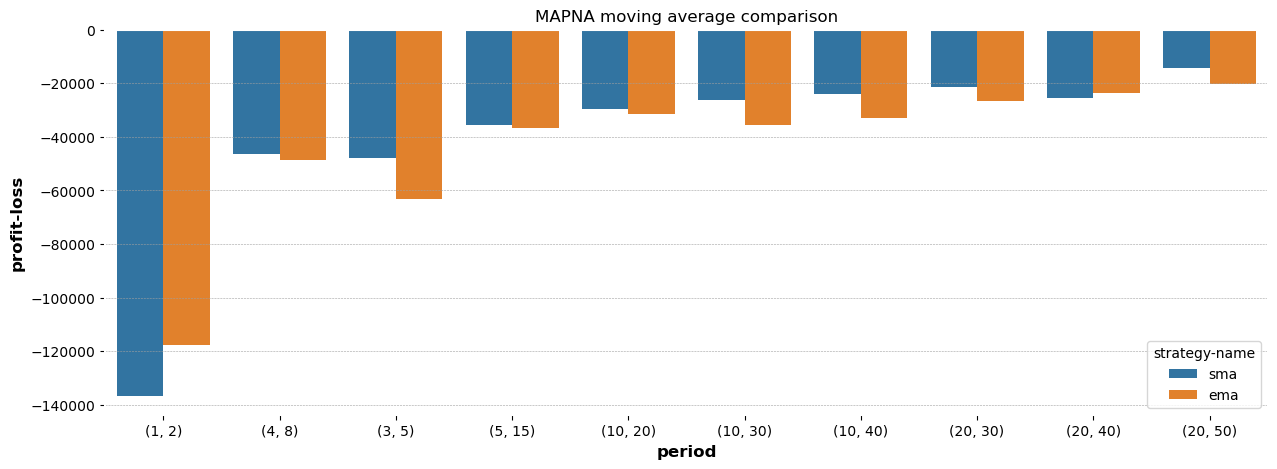

In [18]:
simulator.stock_compare_sma_and_ema(SAMPLE_STOCK_NAME)

#### Order count diff sma vs ema

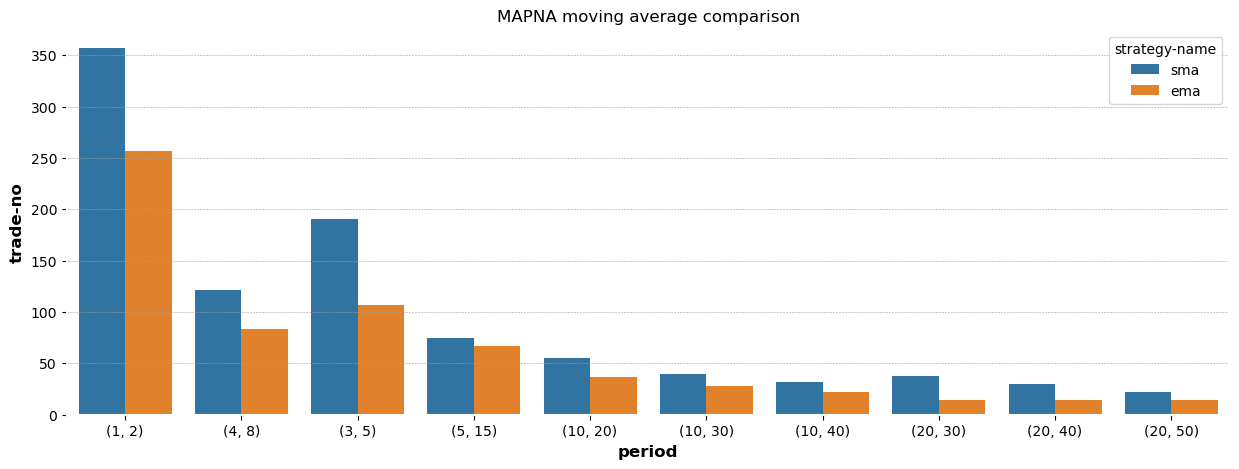

In [19]:
simulator.compare_order_count(stock_name=SAMPLE_STOCK_NAME)

### Linear Regression

In [20]:
lr_sim = LrSimulator(stock_holder.get_samples(), stock_holder.get_stock_names(), save_data=SAVE_DATA)

#### plot regions

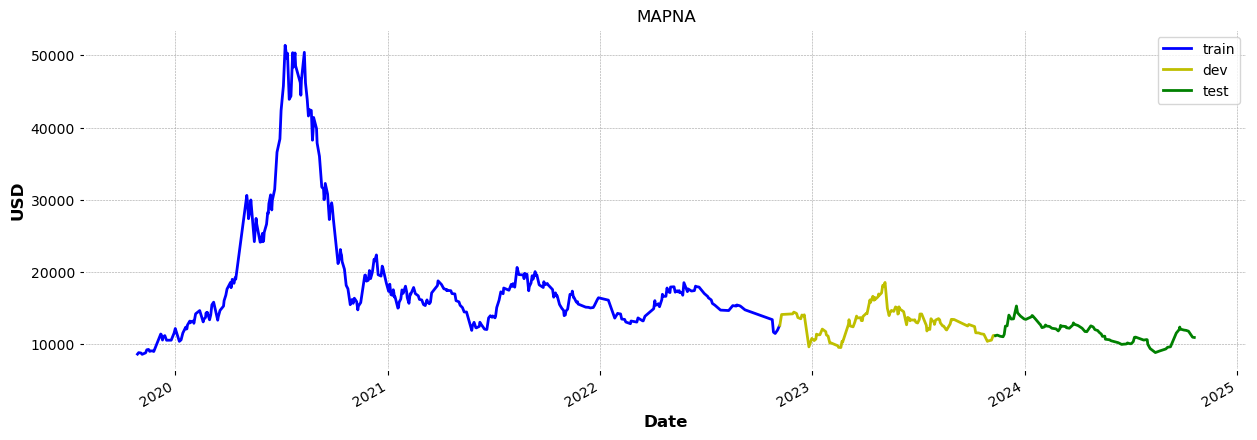

In [21]:
lr_sim.plot_regions(SAMPLE_STOCK_NAME)

#### apply regression

In [22]:
lr_sim.apply_regressions()

#### plotting parameters

##### rms

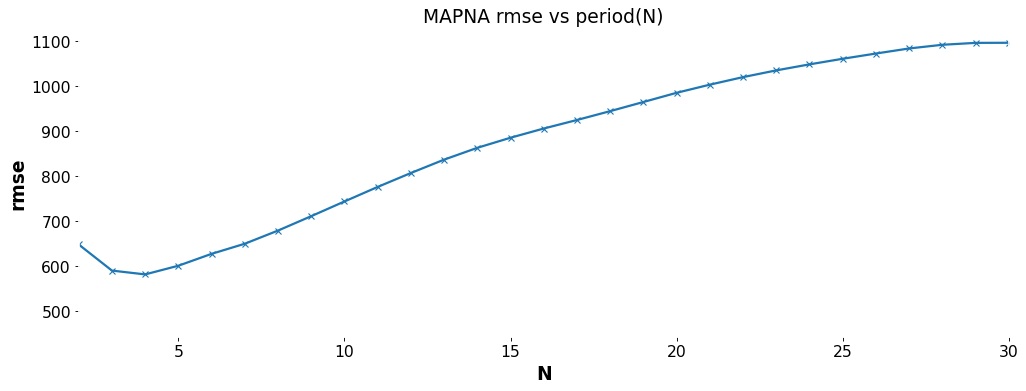

In [23]:
lr_sim.plot_param_vs_period(SAMPLE_STOCK_NAME, LinearRegressionModel.rmse)

##### r2

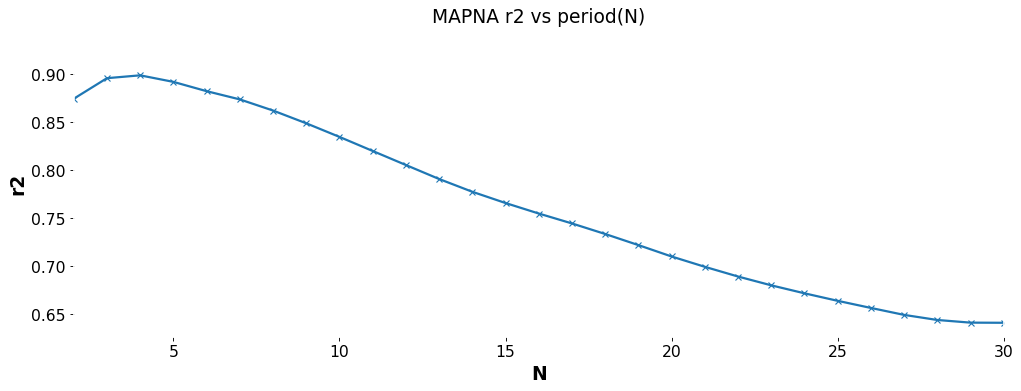

In [24]:
lr_sim.plot_param_vs_period(SAMPLE_STOCK_NAME, LinearRegressionModel.r2)

##### mape

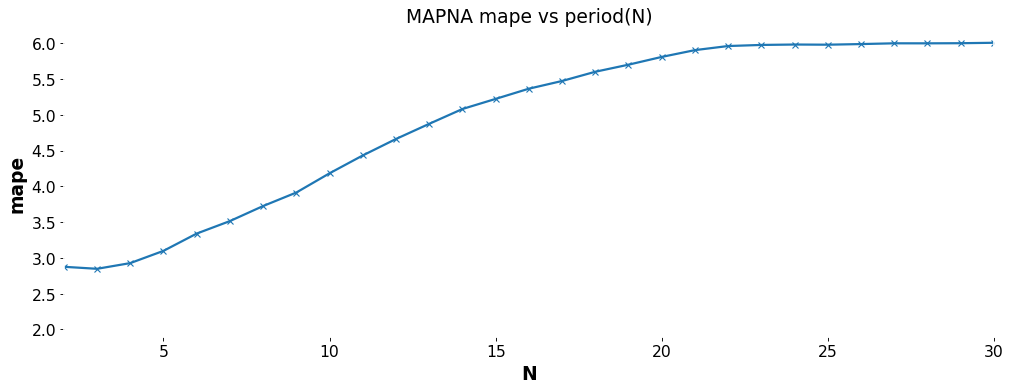

In [25]:
lr_sim.plot_param_vs_period(SAMPLE_STOCK_NAME, LinearRegressionModel.mape)

#### Predicting future days

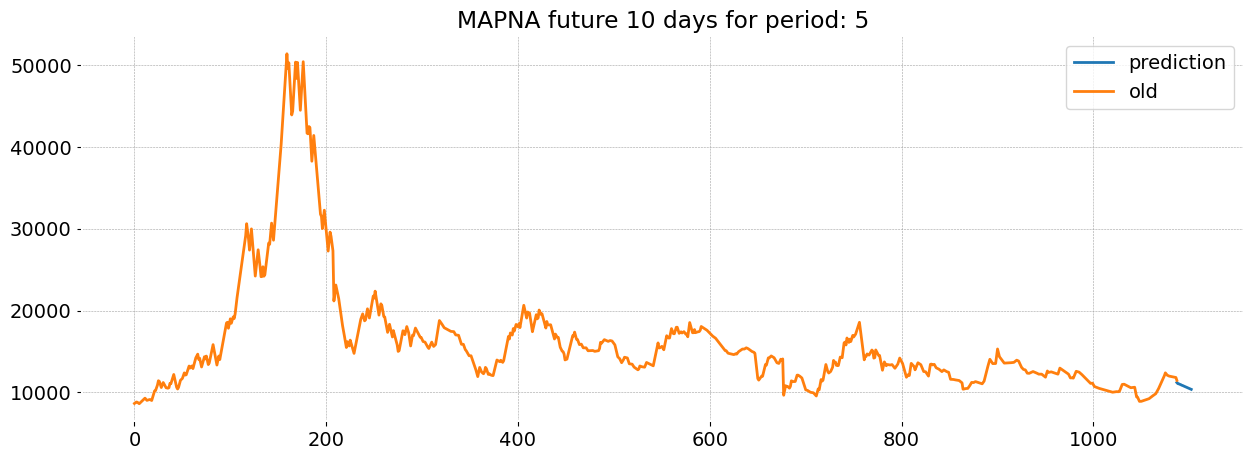

,Behpardakht.Mellat,Iran.Kh..A..M.,IranAntibiotic.MFG,MAPNA,S_I..N..C..Ind.,S_Isf..Oil.Ref.Co.
0,5746.000000,24379.000000,22255.000000,10878.000000,5963.000000,3315.500000
1,5759.800000,24185.200000,22044.000000,10842.400000,5881.400000,3229.300000
2,5791.840000,24018.660000,22017.700000,10783.920000,5803.620000,3142.790000
3,5823.572000,24100.328000,21772.160000,10732.936000,5698.196000,3046.182000
4,5848.137600,24028.732400,21749.878000,10678.988800,5632.346800,2958.650600
5,5874.284080,23906.761920,21583.122400,10631.003040,5542.359440,2869.439480
6,5905.106464,23883.895336,21476.498920,10575.532032,5456.778152,2778.114284
7,5931.761531,23848.746909,21338.439936,10524.863306,5371.804002,2687.207087
8,5958.576713,23759.293139,21241.774089,10472.783988,5291.791085,2598.372848
9,5987.079981,23706.417881,21099.675583,10421.069426,5203.515835,2507.520491


In [26]:
pred_df = lr_sim.predict_future_days(plot_list=[SAMPLE_STOCK_NAME])
pred_df